In [56]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [38]:
df = pd.read_csv('spam1.csv',encoding='ISO-8859-1')
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### 1. [Theory] What are the basic assumptions of the Naive Bayes algorithm?
The Naive Bayes algorithm is a probabilistic classifier based on Bayes’ Theorem, and it makes several key assumptions to simplify the computation. Here are the basic assumptions:
- **Feature Independence (Naivety Assumption)**
    - Assumption: All features (predictors) are conditionally independent given the class label.
    - Implication: The presence or value of a feature is unrelated to the presence or value of any other feature, given the class.
    - Example: In spam detection, if you're classifying emails based on words, Naive Bayes assumes that the occurrence of the word “free” is independent of the word “money,” given that the email is spam.

This is the core "naive" assumption and is often not true in real-world data, but the model still performs surprisingly well in many applications.
- **All Features Contribute Equally and Independently**
    - Each feature contributes independently to the probability of a certain outcome.
    - There is no interaction between features in terms of their influence on the target variable.
- **Correct Class Prior Probabilities**
    - It assumes that the prior probabilities of each class (P(Class)) are either:
        - Known (from training data), or
        - Can be accurately estimated from the data.
- **Correct Likelihood Estimation**
    - It assumes that you can accurately estimate the likelihood 𝑃(𝑋𝑖∣𝐶), which is the probability of feature Xi given class C.
    - For categorical data, frequency-based estimation is often used.
    - For continuous data, you often assume a distribution (e.g., Gaussian) for the features and estimate its parameters from the data.

### 2. [Code] Load the dataset and display the first 5 rows. Mention the shape and number of unique labels.

In [39]:
print("First 5 rows of the dataset:")
print(df.head())

print("\nShape of the dataset:", df.shape)

print("\nUnique labels and their counts:")
print(df['v1'].value_counts())
print("\nNumber of unique labels:", df['v1'].nunique())

First 5 rows of the dataset:
     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Shape of the dataset: (5572, 2)

Unique labels and their counts:
v1
ham     4825
spam     747
Name: count, dtype: int64

Number of unique labels: 2


### 3. [Code] Plot the distribution of spam vs. ham messages using a countplot.

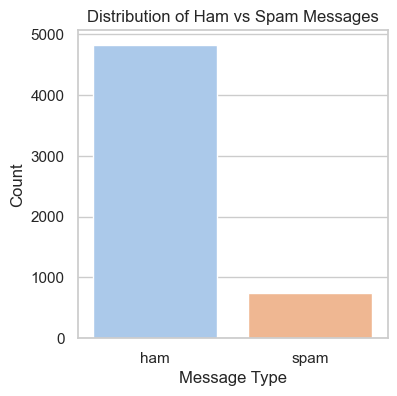

In [40]:
sns.set(style="whitegrid")
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='v1', hue='v1', palette='pastel', legend=False)

plt.title('Distribution of Ham vs Spam Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

### 4. [Theory] Why is Naive Bayes preferred for text classification tasks?
Naive Bayes is widely preferred for text classification tasks (like spam detection, sentiment analysis, etc.) due to the following key reasons:

**1. Simplicity and Efficiency**
- Naive Bayes is computationally very fast — both for training and prediction.
- It works well even with large feature spaces, which is common in text data (thousands of words).

**2. Handles High-Dimensional Data**
- Text data converted via Bag of Words or TF-IDF results in sparse, high-dimensional vectors.
- Naive Bayes handles this effectively without needing dimensionality reduction.

**3. Performs Well Even with Limited Data**
- Unlike some complex models, Naive Bayes performs surprisingly well with small datasets.
- It assumes feature independence, which simplifies learning even with fewer examples.

**4. Probabilistic Output**
- It provides probability scores for each class, making it interpretable and useful when confidence in predictions is important.

**5. Good Baseline Model**
- Despite its simplicity, it often performs competitively with more complex models.
- It’s commonly used as a baseline in text classification tasks.

### 5. [Code] Clean the text column: lowercasing, removing special characters, and stopwords. Show 5 cleaned examples.

In [41]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and digits
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df['cleaned_message'] = df['v2'].apply(clean_text)
print(df[['v2', 'cleaned_message']].head())

                                                  v2  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


[nltk_data] Downloading package stopwords to C:\Users\Hasti
[nltk_data]     Gohel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 6. [Code] Convert text into numerical format using CountVectorizer or TfidfVectorizer.

In [42]:
tfidf = TfidfVectorizer()

X_tfidf = tfidf.fit_transform(df['cleaned_message'])
print("Shape of TfidfVectorizer output:", X_tfidf.shape)

Shape of TfidfVectorizer output: (5572, 8389)


### 7. [Code] Split the data into train and test sets using an 80-20 ratio.

In [43]:
cv = CountVectorizer()
X_cv = cv.fit_transform(df['cleaned_message'])

df['label_num'] = df['v1'].map({'ham': 0, 'spam': 1})
y = df['label_num']

X = X_cv 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

X_train shape: (4457, 8389)
X_test shape: (1115, 8389)
y_train distribution:
 label_num
0    3859
1     598
Name: count, dtype: int64
y_test distribution:
 label_num
0    966
1    149
Name: count, dtype: int64


### 8. [Code] Train a Multinomial Naive Bayes classifier on the vectorized training data.

In [44]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


### 9. [Code] Predict on the test set and print metrics like accuracy, precision, recall, and F1-score.

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = nb_model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Accuracy : 0.9695067264573991
Precision: 0.8616352201257862
Recall   : 0.9194630872483222
F1 Score : 0.8896103896103896

Classification Report:

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       966
        Spam       0.86      0.92      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.95      0.94      1115
weighted avg       0.97      0.97      0.97      1115



### 10. [Theory] What is the difference between Multinomial, Bernoulli, and Gaussian Naive Bayes?

1. **Multinomial Naive Bayes**
- Used For: Text classification, document classification (e.g., spam detection)
- Feature Type: Discrete counts (e.g., word frequencies or TF-IDF scores)
- Assumes: Features (words) follow a multinomial distribution
- Example: Number of times a word appears in an email
- Best when: Features are count-based (e.g., CountVectorizer, TfidfVectorizer outputs)

2. **Bernoulli Naive Bayes**
- Used For: Binary/boolean feature data
- Feature Type: 0 or 1 (presence/absence of a word)
- Assumes: Features follow a Bernoulli distribution (binary outcome)
- Example: Whether a specific word is present in a document (1 = yes, 0 = no)
- Best when: Data is binary, like "word present or not"

3. **Gaussian Naive Bayes**
- Used For: Continuous/numeric data (not text)
- Feature Type: Real-valued inputs
- Assumes: Features are drawn from a Gaussian (normal) distribution
- Example: Age, height, salary, etc.
- Best when: You're dealing with continuous features that are normally distributed

| Model          | Input Type           | Use Case                          | Distribution Assumed |
| -------------- | -------------------- | --------------------------------- | -------------------- |
| Multinomial NB | Counts / Frequencies | Text classification (word counts) | Multinomial          |
| Bernoulli NB   | Binary (0/1)         | Binary features (word presence)   | Bernoulli            |
| Gaussian NB    | Continuous values    | General classification (non-text) | Gaussian (Normal)    |

### 11. [Code] Display a confusion matrix using seaborn.heatmap() and explain your observations.
**Observations:**
- High Accuracy:
    - Out of 1,115 total messages, 1,081 are correctly classified.
    - Accuracy ≈ (944 + 137) / 1115 = 0.9695 or ~97%.
- Low False Negative Rate:
    - Only 12 actual spam messages were misclassified as ham.
    - This is good because we don’t want spam messages slipping through.
- Few False Positives:
    - 22 ham messages wrongly flagged as spam.
    - May annoy users but still manageable.
- True Positives (137):
    - Spam detected correctly — a strong sign of classifier performance.

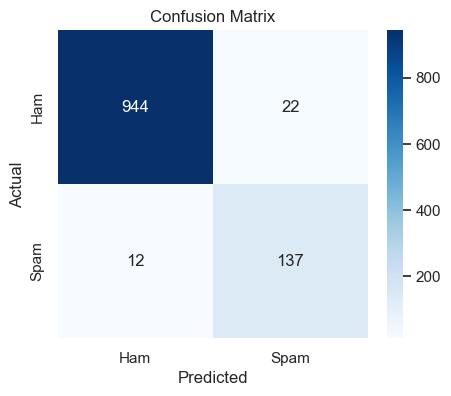

In [48]:
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 12. [Code] Show top 10 most informative features (words) associated with spam messages.

In [51]:
feature_names = cv.get_feature_names_out()

# Classes: [0 = ham, 1 = spam]
spam_class_index = list(nb_model.classes_).index(1)
log_probs = nb_model.feature_log_prob_[spam_class_index]

top_indices = np.argsort(log_probs)[-10:][::-1]  # Top 10

print("Top 10 most indicative words of spam:")
for i in top_indices:
    print(f"{feature_names[i]} — log prob: {log_probs[i]:.4f}")

Top 10 most indicative words of spam:
call — log prob: -4.0877
free — log prob: -4.5371
txt — log prob: -4.9067
ur — log prob: -4.9398
claim — log prob: -5.1650
text — log prob: -5.1863
stop — log prob: -5.1971
mobile — log prob: -5.2416
reply — log prob: -5.2881
prize — log prob: -5.5142


### 13. [Code + Explain] Handle class imbalance using SMOTE or Random Oversampling and retrain the model. Compare results.
| Metric           | **Before SMOTE**       | **After SMOTE**     |
| ---------------- | ---------------------- | ------------------- |
| Accuracy         | \~97%                  | **96%**             |
| Precision (Spam) | \~86–96% (likely high) | **81%**   |
| Recall (Spam)    | \~85% or less          | **89%**  |
| F1 Score (Spam)  | \~85–87%               | **85%**  |

- **Observations:**
- Recall (Spam) improved from ~85% → 89%
    - Meaning fewer spam messages are missed
- Precision (Spam) dropped slightly
    - A few more ham messages might now be misclassified as spam — this is expected with oversampling.
- Overall F1 is balanced → Good trade-off

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_cv, df['v1'].map({'ham': 0, 'spam': 1}), 
                                                    test_size=0.2, random_state=42, stratify=df['v1'])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", dict(zip(*np.unique(y_train_resampled, return_counts=True))))

nb_smote = MultinomialNB()
nb_smote.fit(X_train_resampled, y_train_resampled)

y_pred_smote = nb_smote.predict(X_test)

print("Evaluation after SMOTE:")
print(classification_report(y_test, y_pred_smote, target_names=['Ham', 'Spam']))

Before SMOTE: {0: 3859, 1: 598}
After SMOTE : {0: 3859, 1: 3859}
Evaluation after SMOTE:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98       966
        Spam       0.81      0.89      0.85       149

    accuracy                           0.96      1115
   macro avg       0.90      0.93      0.91      1115
weighted avg       0.96      0.96      0.96      1115



### 14. [Code + Bonus] Build a simple text classifier pipeline using Pipeline from sklearn. Include preprocessing + vectorization + model steps.

In [57]:
X = df['v2']  # text messages
y = df['v1'].map({'ham': 0, 'spam': 1})  # labels as 0/1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('nb', MultinomialNB())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Classification Report:

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

